# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4626206e5f1330256f41fa403b43482ae6d57435de22fbf66d6b70730bea4933
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=0505bf5ae44a63a415d778b1b98d27357476ad38e9228446a49390e4cf14f330
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = v2.Compose([     v2.Resize(size), 
                                             #v2.RandomHorizontalFlip(),  # 随机水平翻转
                                             #v2.RandomVerticalFlip(),    # 随机垂直旋转
                                             #v2.RandomRotation(10) ,     # 随机旋转 （-10,10）度
                                             v2.ToImageTensor(), v2.ConvertImageDtype()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        #seed = np.random.randint(2147483647)
        #torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        orig_img = self.transform(orig_img)
        #torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 38: 


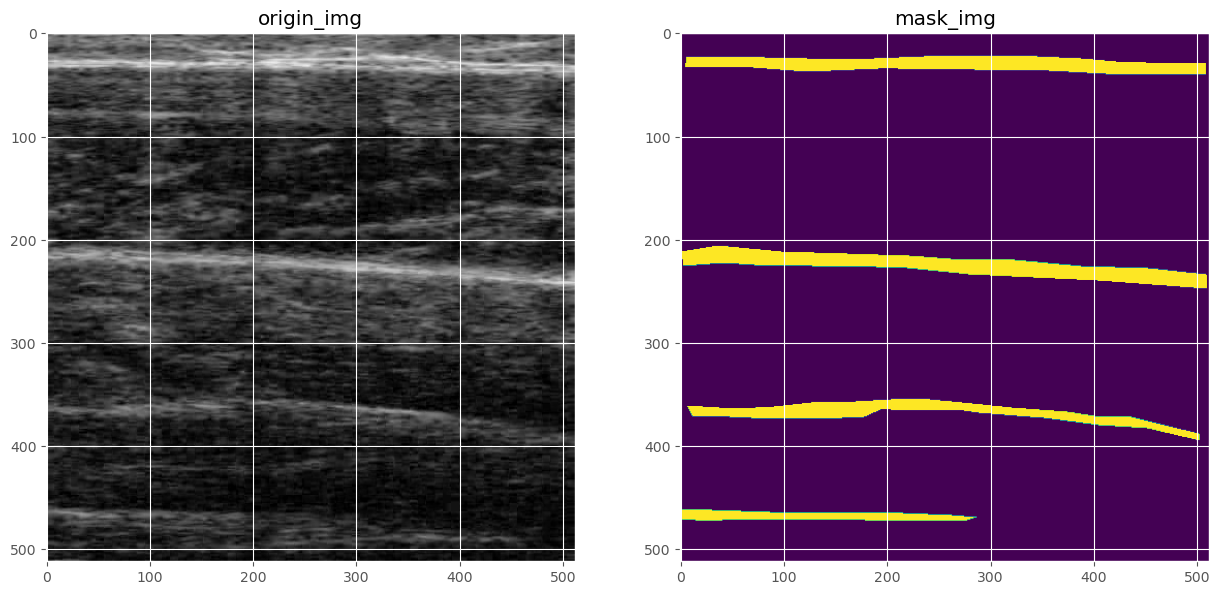

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = v2.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)

sigmoid = nn.Sigmoid()

def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        logging.info('Validation Dice score: {}'.format(val_score))
                        
                        predict = sigmoid(masks_pred[0])
                        predict = torch.where(predict>0.5,torch.ones_like(predict),torch.zeros_like(predict))

                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(predict.float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device)

    

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240118_101458-p96t3dq1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run jolly-snowball-23
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/U-Net
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/U-Net/runs/p96t3dq1
Epoch 1/60:  20%|█▉        | 90/456 [00:17<01:01,  5.91img/s, loss (batch)=1.52]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 2.8890140056610107, IoU Score 0.26447874307632446


Epoch 1/60:  39%|███▉      | 180/456 [00:47<00:47,  5.82img/s, loss (batch)=1.24]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 2.406412124633789, IoU Score 0.35236912965774536


Epoch 1/60:  59%|█████▉    | 270/456 [01:17<00:33,  5.59img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.52batch/s]


Validation dice loss: 2.1007165908813477, IoU Score 0.5687796473503113


Epoch 1/60:  79%|███████▉  | 360/456 [01:48<00:16,  5.65img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 2.028954029083252, IoU Score 0.5869616866111755


Epoch 1/60:  99%|█████████▊| 450/456 [02:18<00:01,  5.67img/s, loss (batch)=1.26]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 2.0622551441192627, IoU Score 0.5675877928733826


Epoch 2/60:  18%|█▊        | 84/456 [00:15<01:10,  5.30img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.05batch/s]


Validation dice loss: 2.0931625366210938, IoU Score 0.5593296885490417


Epoch 2/60:  38%|███▊      | 174/456 [00:47<00:52,  5.41img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.52batch/s]


Validation dice loss: 1.9822959899902344, IoU Score 0.6045436859130859


Epoch 2/60:  58%|█████▊    | 264/456 [01:18<00:34,  5.62img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.8887838125228882, IoU Score 0.5733188986778259


Epoch 2/60:  78%|███████▊  | 354/456 [01:49<00:18,  5.57img/s, loss (batch)=1.25]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 2.0008091926574707, IoU Score 0.5622835159301758


Epoch 2/60:  97%|█████████▋| 444/456 [02:20<00:02,  5.72img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.866156816482544, IoU Score 0.5812129378318787


Epoch 3/60:  17%|█▋        | 78/456 [00:13<01:06,  5.69img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.8321117162704468, IoU Score 0.6084315180778503


Epoch 3/60:  37%|███▋      | 168/456 [00:44<00:50,  5.72img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.8235039710998535, IoU Score 0.6272271871566772


Epoch 3/60:  57%|█████▋    | 258/456 [01:14<00:35,  5.63img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.7163974046707153, IoU Score 0.6158031821250916


Epoch 3/60:  76%|███████▋  | 348/456 [01:45<00:19,  5.68img/s, loss (batch)=0.965]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.7684093713760376, IoU Score 0.6407814025878906


Epoch 3/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.66img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.7165311574935913, IoU Score 0.6095302700996399


Epoch 4/60:  16%|█▌        | 72/456 [00:12<01:06,  5.74img/s, loss (batch)=0.929]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.7751786708831787, IoU Score 0.6322506070137024


Epoch 4/60:  36%|███▌      | 162/456 [00:43<00:51,  5.66img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.777405858039856, IoU Score 0.6214128136634827


Epoch 4/60:  55%|█████▌    | 252/456 [01:13<00:35,  5.68img/s, loss (batch)=1.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.6898611783981323, IoU Score 0.6475783586502075


Epoch 4/60:  75%|███████▌  | 342/456 [01:44<00:20,  5.55img/s, loss (batch)=0.971]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.6246598958969116, IoU Score 0.5908021926879883


Epoch 4/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.65img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.6515289545059204, IoU Score 0.5805683135986328


Epoch 5/60:  14%|█▍        | 66/456 [00:11<01:09,  5.64img/s, loss (batch)=0.988]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6694058179855347, IoU Score 0.5904048085212708


Epoch 5/60:  34%|███▍      | 156/456 [00:41<00:52,  5.67img/s, loss (batch)=0.878]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.6375211477279663, IoU Score 0.6178268790245056


Epoch 5/60:  54%|█████▍    | 246/456 [01:12<00:36,  5.69img/s, loss (batch)=1.05] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.6196613311767578, IoU Score 0.6356110572814941


Epoch 5/60:  74%|███████▎  | 336/456 [01:42<00:21,  5.70img/s, loss (batch)=0.855]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6063576936721802, IoU Score 0.634510338306427


Epoch 5/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.73img/s, loss (batch)=0.838]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.5586495399475098, IoU Score 0.6079704761505127


Epoch 6/60:  13%|█▎        | 60/456 [00:10<01:10,  5.63img/s, loss (batch)=0.966]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.5249286890029907, IoU Score 0.6280637383460999


Epoch 6/60:  33%|███▎      | 150/456 [00:40<00:53,  5.68img/s, loss (batch)=0.951]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.5344032049179077, IoU Score 0.6261970400810242


Epoch 6/60:  53%|█████▎    | 240/456 [01:11<00:37,  5.79img/s, loss (batch)=0.859]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.4776808023452759, IoU Score 0.6454391479492188


Epoch 6/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.64img/s, loss (batch)=0.83]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.523249626159668, IoU Score 0.6530167460441589


Epoch 6/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.62img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.4676998853683472, IoU Score 0.6271231174468994


Epoch 7/60:  12%|█▏        | 54/456 [00:09<01:11,  5.61img/s, loss (batch)=0.94] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.5527862310409546, IoU Score 0.6430974006652832


Epoch 7/60:  32%|███▏      | 144/456 [00:39<00:54,  5.71img/s, loss (batch)=0.889]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4937975406646729, IoU Score 0.6318394541740417


Epoch 7/60:  51%|█████▏    | 234/456 [01:10<00:39,  5.68img/s, loss (batch)=0.947]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.5704089403152466, IoU Score 0.6094055771827698


Epoch 7/60:  71%|███████   | 324/456 [01:41<00:23,  5.61img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.4789737462997437, IoU Score 0.6501070857048035


Epoch 7/60:  91%|█████████ | 414/456 [02:11<00:07,  5.71img/s, loss (batch)=0.909]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.36batch/s]


Validation dice loss: 1.3985837697982788, IoU Score 0.6463556885719299


Epoch 8/60:  11%|█         | 48/456 [00:08<01:17,  5.29img/s, loss (batch)=0.953]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.4157941341400146, IoU Score 0.6577608585357666


Epoch 8/60:  30%|███       | 138/456 [00:39<00:56,  5.66img/s, loss (batch)=0.854]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.422303557395935, IoU Score 0.6413571834564209


Epoch 8/60:  50%|█████     | 228/456 [01:09<00:40,  5.65img/s, loss (batch)=0.792]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.3871573209762573, IoU Score 0.6383041143417358


Epoch 8/60:  70%|██████▉   | 318/456 [01:40<00:24,  5.69img/s, loss (batch)=0.744]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.3792144060134888, IoU Score 0.6252127885818481


Epoch 8/60:  89%|████████▉ | 408/456 [02:10<00:08,  5.54img/s, loss (batch)=0.923]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.3821723461151123, IoU Score 0.6461713314056396


Epoch 9/60:   9%|▉         | 42/456 [00:07<01:12,  5.68img/s, loss (batch)=0.828]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.3483257293701172, IoU Score 0.6505758166313171


Epoch 9/60:  29%|██▉       | 132/456 [00:37<00:57,  5.64img/s, loss (batch)=0.763]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.3150067329406738, IoU Score 0.6519789099693298


Epoch 9/60:  49%|████▊     | 222/456 [01:08<00:41,  5.69img/s, loss (batch)=0.82] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.3569040298461914, IoU Score 0.6474609971046448


Epoch 9/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.64img/s, loss (batch)=0.796]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.3193508386611938, IoU Score 0.6299371123313904


Epoch 9/60:  88%|████████▊ | 402/456 [02:09<00:09,  5.66img/s, loss (batch)=0.913]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.2837177515029907, IoU Score 0.6559581160545349


Epoch 10/60:   8%|▊         | 36/456 [00:06<01:16,  5.52img/s, loss (batch)=0.86] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.348877191543579, IoU Score 0.6304217576980591


Epoch 10/60:  28%|██▊       | 126/456 [00:36<00:58,  5.64img/s, loss (batch)=0.722]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.3103861808776855, IoU Score 0.6378291845321655


Epoch 10/60:  47%|████▋     | 216/456 [01:07<00:41,  5.73img/s, loss (batch)=0.864]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.258608102798462, IoU Score 0.6261782050132751


Epoch 10/60:  67%|██████▋   | 306/456 [01:38<00:26,  5.72img/s, loss (batch)=0.76] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.31batch/s]


Validation dice loss: 1.2837638854980469, IoU Score 0.6341524720191956


Epoch 10/60:  87%|████████▋ | 396/456 [02:09<00:10,  5.66img/s, loss (batch)=0.953]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.2763296365737915, IoU Score 0.6567655801773071


Epoch 11/60:   7%|▋         | 30/456 [00:05<01:14,  5.68img/s, loss (batch)=0.8]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.2337515354156494, IoU Score 0.6545000672340393


Epoch 11/60:  26%|██▋       | 120/456 [00:35<00:59,  5.66img/s, loss (batch)=0.767]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2451692819595337, IoU Score 0.6705397963523865


Epoch 11/60:  46%|████▌     | 210/456 [01:06<00:43,  5.71img/s, loss (batch)=0.661]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.2708343267440796, IoU Score 0.6489484310150146


Epoch 11/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.62img/s, loss (batch)=0.899]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.2440533638000488, IoU Score 0.6532043814659119


Epoch 11/60:  86%|████████▌ | 390/456 [02:07<00:11,  5.63img/s, loss (batch)=0.734]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.275938868522644, IoU Score 0.6455535888671875


Epoch 12/60:   5%|▌         | 24/456 [00:04<01:28,  4.90img/s, loss (batch)=0.589]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.2420293092727661, IoU Score 0.6588109731674194


Epoch 12/60:  25%|██▌       | 114/456 [00:34<00:59,  5.72img/s, loss (batch)=0.658]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.221793532371521, IoU Score 0.6478086113929749


Epoch 12/60:  45%|████▍     | 204/456 [01:05<00:44,  5.66img/s, loss (batch)=1.06] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.2716658115386963, IoU Score 0.6390852332115173


Epoch 12/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.76img/s, loss (batch)=0.7]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.1643368005752563, IoU Score 0.6643169522285461


Epoch 12/60:  84%|████████▍ | 384/456 [02:06<00:12,  5.68img/s, loss (batch)=0.722]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.179121732711792, IoU Score 0.6624706983566284


Epoch 13/60:   4%|▍         | 18/456 [00:03<01:18,  5.61img/s, loss (batch)=0.899]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.1890838146209717, IoU Score 0.6473669409751892


Epoch 13/60:  24%|██▎       | 108/456 [00:33<01:01,  5.69img/s, loss (batch)=0.715]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1704262495040894, IoU Score 0.6247275471687317


Epoch 13/60:  43%|████▎     | 198/456 [01:03<00:44,  5.74img/s, loss (batch)=0.756]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.173459529876709, IoU Score 0.6510160565376282


Epoch 13/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.68img/s, loss (batch)=0.634]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1884444952011108, IoU Score 0.6469093561172485


Epoch 13/60:  83%|████████▎ | 378/456 [02:04<00:13,  5.65img/s, loss (batch)=0.808]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.156192660331726, IoU Score 0.6445508003234863


Epoch 14/60:   3%|▎         | 12/456 [00:02<01:18,  5.68img/s, loss (batch)=0.747]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.1310054063796997, IoU Score 0.6647085547447205


Epoch 14/60:  22%|██▏       | 102/456 [00:32<01:02,  5.70img/s, loss (batch)=0.825]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.1641359329223633, IoU Score 0.656138002872467


Epoch 14/60:  42%|████▏     | 192/456 [01:02<00:46,  5.70img/s, loss (batch)=0.783]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.1499720811843872, IoU Score 0.6534928679466248


Epoch 14/60:  62%|██████▏   | 282/456 [01:33<00:31,  5.61img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.2495439052581787, IoU Score 0.588346540927887


Epoch 14/60:  82%|████████▏ | 372/456 [02:03<00:14,  5.77img/s, loss (batch)=0.707]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.1100925207138062, IoU Score 0.6622453927993774


Epoch 15/60:   1%|▏         | 6/456 [00:01<01:19,  5.69img/s, loss (batch)=0.729]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.1180022954940796, IoU Score 0.6657528281211853


Epoch 15/60:  21%|██        | 96/456 [00:31<01:04,  5.62img/s, loss (batch)=0.644]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.1111737489700317, IoU Score 0.6444360017776489


Epoch 15/60:  41%|████      | 186/456 [01:01<00:47,  5.66img/s, loss (batch)=0.67] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1041486263275146, IoU Score 0.6548981070518494


Epoch 15/60:  61%|██████    | 276/456 [01:32<00:31,  5.66img/s, loss (batch)=0.95] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.1025192737579346, IoU Score 0.6577038168907166


Epoch 15/60:  80%|████████  | 366/456 [02:02<00:15,  5.66img/s, loss (batch)=0.722]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.0875004529953003, IoU Score 0.6546592712402344


Epoch 15/60: 100%|██████████| 456/456 [02:33<00:00,  5.63img/s, loss (batch)=0.788]

Validation round


Epoch 15/60: 100%|██████████| 456/456 [02:47<00:00,  2.72img/s, loss (batch)=0.788]


Validation dice loss: 1.1752793788909912, IoU Score 0.639350175857544


Epoch 16/60:  20%|█▉        | 90/456 [00:16<01:05,  5.61img/s, loss (batch)=0.861]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.1328743696212769, IoU Score 0.6464351415634155


Epoch 16/60:  39%|███▉      | 180/456 [00:46<00:48,  5.71img/s, loss (batch)=0.679]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.0774208307266235, IoU Score 0.6535389423370361


Epoch 16/60:  59%|█████▉    | 270/456 [01:16<00:33,  5.60img/s, loss (batch)=0.668]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.1352152824401855, IoU Score 0.6255888938903809


Epoch 16/60:  79%|███████▉  | 360/456 [01:47<00:18,  5.12img/s, loss (batch)=0.62]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.1438696384429932, IoU Score 0.6104139685630798


Epoch 16/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.34img/s, loss (batch)=0.624]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 1.0307291746139526, IoU Score 0.6635577082633972


Epoch 17/60:  18%|█▊        | 84/456 [00:14<01:05,  5.71img/s, loss (batch)=0.792]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.047806739807129, IoU Score 0.6698055267333984


Epoch 17/60:  38%|███▊      | 174/456 [00:45<00:49,  5.67img/s, loss (batch)=0.573]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.042483925819397, IoU Score 0.6672142148017883


Epoch 17/60:  58%|█████▊    | 264/456 [01:15<00:34,  5.64img/s, loss (batch)=0.661]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.017628788948059, IoU Score 0.6494576930999756


Epoch 17/60:  78%|███████▊  | 354/456 [01:46<00:18,  5.65img/s, loss (batch)=0.788]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.04023015499115, IoU Score 0.6642170548439026


Epoch 17/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.74img/s, loss (batch)=0.628]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.0222711563110352, IoU Score 0.6655001044273376


Epoch 18/60:  17%|█▋        | 78/456 [00:13<01:05,  5.74img/s, loss (batch)=0.588]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.0930105447769165, IoU Score 0.6051302552223206


Epoch 18/60:  37%|███▋      | 168/456 [00:44<00:50,  5.70img/s, loss (batch)=0.651]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.076239824295044, IoU Score 0.6303744316101074


Epoch 18/60:  57%|█████▋    | 258/456 [01:14<00:34,  5.71img/s, loss (batch)=0.893]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.9927301406860352, IoU Score 0.651277482509613


Epoch 18/60:  76%|███████▋  | 348/456 [01:44<00:19,  5.67img/s, loss (batch)=0.689]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.1833220720291138, IoU Score 0.536893367767334


Epoch 18/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.67img/s, loss (batch)=0.726]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.1048235893249512, IoU Score 0.5922350287437439


Epoch 19/60:  16%|█▌        | 72/456 [00:12<01:08,  5.58img/s, loss (batch)=0.619]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.0624741315841675, IoU Score 0.6335084438323975


Epoch 19/60:  36%|███▌      | 162/456 [00:42<00:52,  5.63img/s, loss (batch)=0.605]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.9557493329048157, IoU Score 0.6720775365829468


Epoch 19/60:  55%|█████▌    | 252/456 [01:13<00:35,  5.70img/s, loss (batch)=0.545]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.1676374673843384, IoU Score 0.5570701956748962


Epoch 19/60:  75%|███████▌  | 342/456 [01:43<00:19,  5.74img/s, loss (batch)=0.557]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.9478265047073364, IoU Score 0.6625255346298218


Epoch 19/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.65img/s, loss (batch)=0.65] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.9218149781227112, IoU Score 0.6024896502494812


Epoch 20/60:  14%|█▍        | 66/456 [00:11<01:08,  5.66img/s, loss (batch)=0.709]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.9279760122299194, IoU Score 0.6161145567893982


Epoch 20/60:  34%|███▍      | 156/456 [00:42<00:54,  5.47img/s, loss (batch)=0.72] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.9291204810142517, IoU Score 0.6268696188926697


Epoch 20/60:  54%|█████▍    | 246/456 [01:13<00:37,  5.60img/s, loss (batch)=0.884]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.9427065253257751, IoU Score 0.58817058801651


Epoch 20/60:  74%|███████▎  | 336/456 [01:43<00:21,  5.62img/s, loss (batch)=0.437]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.811283528804779, IoU Score 0.6131322383880615


Epoch 20/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.69img/s, loss (batch)=0.479]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.8520556688308716, IoU Score 0.6317527890205383


Epoch 21/60:  13%|█▎        | 60/456 [00:10<01:10,  5.61img/s, loss (batch)=0.668]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.8674371242523193, IoU Score 0.636002242565155


Epoch 21/60:  33%|███▎      | 150/456 [00:40<00:54,  5.64img/s, loss (batch)=0.438]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.9774565100669861, IoU Score 0.5307605862617493


Epoch 21/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.64img/s, loss (batch)=0.516]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.9132649302482605, IoU Score 0.5845114588737488


Epoch 21/60:  72%|███████▏  | 330/456 [01:41<00:21,  5.75img/s, loss (batch)=0.476]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.751587986946106, IoU Score 0.6424845457077026


Epoch 21/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.69img/s, loss (batch)=0.408]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.7524922490119934, IoU Score 0.6361610293388367


Epoch 22/60:  12%|█▏        | 54/456 [00:09<01:10,  5.68img/s, loss (batch)=0.429]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.7280768752098083, IoU Score 0.6540877223014832


Epoch 22/60:  32%|███▏      | 144/456 [00:39<00:55,  5.65img/s, loss (batch)=0.646]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.7320646047592163, IoU Score 0.6160314679145813


Epoch 22/60:  51%|█████▏    | 234/456 [01:10<00:38,  5.72img/s, loss (batch)=0.442]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6865068078041077, IoU Score 0.6627270579338074


Epoch 22/60:  71%|███████   | 324/456 [01:40<00:23,  5.68img/s, loss (batch)=0.455]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.9651892781257629, IoU Score 0.511824369430542


Epoch 22/60:  91%|█████████ | 414/456 [02:11<00:07,  5.58img/s, loss (batch)=0.398]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.7271432280540466, IoU Score 0.58951336145401


Epoch 23/60:  11%|█         | 48/456 [00:08<01:11,  5.72img/s, loss (batch)=0.462]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6992757320404053, IoU Score 0.6265367269515991


Epoch 23/60:  30%|███       | 138/456 [00:38<00:56,  5.66img/s, loss (batch)=0.719]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.6935204267501831, IoU Score 0.606861412525177


Epoch 23/60:  50%|█████     | 228/456 [01:09<00:40,  5.61img/s, loss (batch)=0.556]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.5949110388755798, IoU Score 0.6450930237770081


Epoch 23/60:  70%|██████▉   | 318/456 [01:39<00:24,  5.72img/s, loss (batch)=0.388]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.7058165073394775, IoU Score 0.6150872111320496


Epoch 23/60:  89%|████████▉ | 408/456 [02:10<00:08,  5.58img/s, loss (batch)=0.513]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5804612040519714, IoU Score 0.6544562578201294


Epoch 24/60:   9%|▉         | 42/456 [00:07<01:13,  5.64img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.5657737851142883, IoU Score 0.6503688097000122


Epoch 24/60:  29%|██▉       | 132/456 [00:37<00:57,  5.62img/s, loss (batch)=0.344]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.5796176791191101, IoU Score 0.6424619555473328


Epoch 24/60:  49%|████▊     | 222/456 [01:07<00:41,  5.68img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5560697317123413, IoU Score 0.6428247094154358


Epoch 24/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.66img/s, loss (batch)=0.317]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5636575818061829, IoU Score 0.6526451706886292


Epoch 24/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.58img/s, loss (batch)=0.454]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5451223850250244, IoU Score 0.6494578123092651


Epoch 25/60:   8%|▊         | 36/456 [00:06<01:13,  5.69img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.6069192290306091, IoU Score 0.6170693039894104


Epoch 25/60:  28%|██▊       | 126/456 [00:36<00:58,  5.69img/s, loss (batch)=0.312]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5736002922058105, IoU Score 0.6539027690887451


Epoch 25/60:  47%|████▋     | 216/456 [01:07<00:42,  5.64img/s, loss (batch)=0.365]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.7207194566726685, IoU Score 0.5696778297424316


Epoch 25/60:  67%|██████▋   | 306/456 [01:37<00:26,  5.67img/s, loss (batch)=0.333]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.516464352607727, IoU Score 0.6435692310333252


Epoch 25/60:  87%|████████▋ | 396/456 [02:08<00:10,  5.62img/s, loss (batch)=0.315]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5221770405769348, IoU Score 0.6430861353874207


Epoch 26/60:   7%|▋         | 30/456 [00:05<01:14,  5.68img/s, loss (batch)=0.38] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.49608802795410156, IoU Score 0.6690645813941956


Epoch 26/60:  26%|██▋       | 120/456 [00:35<00:59,  5.62img/s, loss (batch)=0.394]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5268145799636841, IoU Score 0.645691990852356


Epoch 26/60:  46%|████▌     | 210/456 [01:06<00:43,  5.67img/s, loss (batch)=0.295]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5632537007331848, IoU Score 0.6508831977844238


Epoch 26/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.66img/s, loss (batch)=0.288]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.5714784264564514, IoU Score 0.60209721326828


Epoch 26/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.63img/s, loss (batch)=0.279]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.5324403643608093, IoU Score 0.6139338612556458


Epoch 27/60:   5%|▌         | 24/456 [00:04<01:15,  5.74img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5191317200660706, IoU Score 0.6394972801208496


Epoch 27/60:  25%|██▌       | 114/456 [00:34<01:01,  5.60img/s, loss (batch)=0.248]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.48006537556648254, IoU Score 0.6615064144134521


Epoch 27/60:  45%|████▍     | 204/456 [01:05<00:45,  5.56img/s, loss (batch)=0.375]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.33batch/s]


Validation dice loss: 0.5374676585197449, IoU Score 0.6186694502830505


Epoch 27/60:  64%|██████▍   | 294/456 [01:37<00:29,  5.53img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.33batch/s]


Validation dice loss: 0.4718589782714844, IoU Score 0.6584968566894531


Epoch 27/60:  84%|████████▍ | 384/456 [02:08<00:12,  5.67img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:14<00:00,  7.96batch/s]


Validation dice loss: 0.5135276317596436, IoU Score 0.6287462711334229


Epoch 28/60:   4%|▍         | 18/456 [00:03<01:21,  5.38img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.41batch/s]


Validation dice loss: 0.6552336812019348, IoU Score 0.5638762712478638


Epoch 28/60:  24%|██▎       | 108/456 [00:34<01:00,  5.71img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.6045668125152588, IoU Score 0.6019259095191956


Epoch 28/60:  43%|████▎     | 198/456 [01:04<00:45,  5.66img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.515042781829834, IoU Score 0.6502282619476318


Epoch 28/60:  63%|██████▎   | 288/456 [01:35<00:29,  5.61img/s, loss (batch)=0.805]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5576407313346863, IoU Score 0.6296800971031189


Epoch 28/60:  83%|████████▎ | 378/456 [02:05<00:14,  5.53img/s, loss (batch)=0.3] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.42172151803970337, IoU Score 0.6634747385978699


Epoch 29/60:   3%|▎         | 12/456 [00:02<01:19,  5.59img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5352430939674377, IoU Score 0.6065024137496948


Epoch 29/60:  22%|██▏       | 102/456 [00:32<01:02,  5.65img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.42693275213241577, IoU Score 0.6647207736968994


Epoch 29/60:  42%|████▏     | 192/456 [01:03<00:45,  5.79img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5218959450721741, IoU Score 0.5959227681159973


Epoch 29/60:  62%|██████▏   | 282/456 [01:33<00:30,  5.67img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4565889537334442, IoU Score 0.6395015120506287


Epoch 29/60:  82%|████████▏ | 372/456 [02:04<00:14,  5.69img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5551652312278748, IoU Score 0.584807276725769


Epoch 30/60:   1%|▏         | 6/456 [00:01<01:18,  5.72img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6029772758483887, IoU Score 0.5823118686676025


Epoch 30/60:  21%|██        | 96/456 [00:31<01:04,  5.61img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.49244415760040283, IoU Score 0.6572173833847046


Epoch 30/60:  41%|████      | 186/456 [01:02<00:48,  5.62img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5393654704093933, IoU Score 0.6229396462440491


Epoch 30/60:  61%|██████    | 276/456 [01:32<00:31,  5.66img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5964788198471069, IoU Score 0.5808888673782349


Epoch 30/60:  80%|████████  | 366/456 [02:03<00:15,  5.66img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.46046996116638184, IoU Score 0.6504442095756531


Epoch 30/60: 100%|██████████| 456/456 [02:33<00:00,  5.58img/s, loss (batch)=0.175]

Validation round


Epoch 30/60: 100%|██████████| 456/456 [02:48<00:00,  2.71img/s, loss (batch)=0.175]


Validation dice loss: 0.4363345801830292, IoU Score 0.663737416267395


Epoch 31/60:  20%|█▉        | 90/456 [00:15<01:04,  5.70img/s, loss (batch)=0.524]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.42963942885398865, IoU Score 0.6643067002296448


Epoch 31/60:  39%|███▉      | 180/456 [00:46<00:49,  5.59img/s, loss (batch)=0.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.502396821975708, IoU Score 0.6048343777656555


Epoch 31/60:  59%|█████▉    | 270/456 [01:17<00:32,  5.65img/s, loss (batch)=0.214]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6615622639656067, IoU Score 0.5305095314979553


Epoch 31/60:  79%|███████▉  | 360/456 [01:47<00:16,  5.73img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4446675181388855, IoU Score 0.6350662112236023


Epoch 31/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.60img/s, loss (batch)=0.623]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.41165265440940857, IoU Score 0.6720973253250122


Epoch 32/60:  18%|█▊        | 84/456 [00:14<01:05,  5.66img/s, loss (batch)=0.271]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.40886926651000977, IoU Score 0.668439507484436


Epoch 32/60:  38%|███▊      | 174/456 [00:45<00:50,  5.64img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.42376700043678284, IoU Score 0.6664392352104187


Epoch 32/60:  58%|█████▊    | 264/456 [01:15<00:33,  5.67img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.465292364358902, IoU Score 0.6288353800773621


Epoch 32/60:  78%|███████▊  | 354/456 [01:46<00:17,  5.68img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.39431649446487427, IoU Score 0.6670692563056946


Epoch 32/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.56img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5078244805335999, IoU Score 0.604324221611023


Epoch 33/60:  17%|█▋        | 78/456 [00:13<01:07,  5.62img/s, loss (batch)=0.375]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.3969813883304596, IoU Score 0.6628729701042175


Epoch 33/60:  37%|███▋      | 168/456 [00:44<00:50,  5.65img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4320219159126282, IoU Score 0.6365779042243958


Epoch 33/60:  57%|█████▋    | 258/456 [01:14<00:35,  5.65img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4253452718257904, IoU Score 0.6493896245956421


Epoch 33/60:  76%|███████▋  | 348/456 [01:45<00:19,  5.59img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4998578131198883, IoU Score 0.6013302803039551


Epoch 33/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.69img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4541996419429779, IoU Score 0.6268383264541626


Epoch 34/60:  16%|█▌        | 72/456 [00:12<01:07,  5.68img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.42606621980667114, IoU Score 0.6397004127502441


Epoch 34/60:  36%|███▌      | 162/456 [00:43<00:51,  5.69img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4207553565502167, IoU Score 0.6561568379402161


Epoch 34/60:  55%|█████▌    | 252/456 [01:13<00:35,  5.71img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.43627095222473145, IoU Score 0.6700833439826965


Epoch 34/60:  75%|███████▌  | 342/456 [01:44<00:20,  5.57img/s, loss (batch)=0.244]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4591057598590851, IoU Score 0.6511197090148926


Epoch 34/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.67img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6100578308105469, IoU Score 0.5360680222511292


Epoch 35/60:  14%|█▍        | 66/456 [00:11<01:08,  5.66img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4275052547454834, IoU Score 0.6475245952606201


Epoch 35/60:  34%|███▍      | 156/456 [00:42<00:54,  5.50img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.52batch/s]


Validation dice loss: 0.41675418615341187, IoU Score 0.6471690535545349


Epoch 35/60:  54%|█████▍    | 246/456 [01:13<00:37,  5.54img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4055631160736084, IoU Score 0.6536783576011658


Epoch 35/60:  74%|███████▎  | 336/456 [01:43<00:21,  5.65img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.41103869676589966, IoU Score 0.6535865068435669


Epoch 35/60:  93%|█████████▎| 426/456 [02:14<00:05,  5.72img/s, loss (batch)=0.306]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4063468277454376, IoU Score 0.6490220427513123


Epoch 36/60:  13%|█▎        | 60/456 [00:10<01:09,  5.69img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4199874997138977, IoU Score 0.6470916867256165


Epoch 36/60:  33%|███▎      | 150/456 [00:40<00:53,  5.77img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.3948063254356384, IoU Score 0.666420042514801


Epoch 36/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.67img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.3830600678920746, IoU Score 0.6694700121879578


Epoch 36/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.66img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4423142969608307, IoU Score 0.6369317173957825


Epoch 36/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.69img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.49128976464271545, IoU Score 0.5893481373786926


Epoch 37/60:  12%|█▏        | 54/456 [00:09<01:10,  5.69img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.41151246428489685, IoU Score 0.6523590683937073


Epoch 37/60:  32%|███▏      | 144/456 [00:39<00:54,  5.68img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.4140966534614563, IoU Score 0.6444846987724304


Epoch 37/60:  51%|█████▏    | 234/456 [01:10<00:38,  5.71img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.38334110379219055, IoU Score 0.6707131862640381


Epoch 37/60:  71%|███████   | 324/456 [01:41<00:23,  5.63img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.4878613352775574, IoU Score 0.5953112244606018


Epoch 37/60:  91%|█████████ | 414/456 [02:12<00:07,  5.49img/s, loss (batch)=0.25] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.38906335830688477, IoU Score 0.6583712100982666


Epoch 38/60:  11%|█         | 48/456 [00:08<01:12,  5.63img/s, loss (batch)=0.548]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.53batch/s]


Validation dice loss: 0.4537803530693054, IoU Score 0.6286837458610535


Epoch 38/60:  30%|███       | 138/456 [00:39<00:56,  5.58img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3975321650505066, IoU Score 0.6525824069976807


Epoch 38/60:  50%|█████     | 228/456 [01:10<00:40,  5.58img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4171074628829956, IoU Score 0.6425235867500305


Epoch 38/60:  70%|██████▉   | 318/456 [01:40<00:24,  5.57img/s, loss (batch)=0.57] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4693048894405365, IoU Score 0.602186381816864


Epoch 38/60:  89%|████████▉ | 408/456 [02:11<00:08,  5.60img/s, loss (batch)=0.381]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.3837926685810089, IoU Score 0.6655120253562927


Epoch 39/60:   9%|▉         | 42/456 [00:07<01:13,  5.64img/s, loss (batch)=0.549]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.36722105741500854, IoU Score 0.6712770462036133


Epoch 39/60:  29%|██▉       | 132/456 [00:37<00:58,  5.53img/s, loss (batch)=0.395]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.44972914457321167, IoU Score 0.6156637668609619


Epoch 39/60:  49%|████▊     | 222/456 [01:08<00:41,  5.60img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.40575072169303894, IoU Score 0.6523886322975159


Epoch 39/60:  68%|██████▊   | 312/456 [01:38<00:24,  5.76img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.40061596035957336, IoU Score 0.6510059237480164


Epoch 39/60:  88%|████████▊ | 402/456 [02:09<00:09,  5.64img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.39982232451438904, IoU Score 0.6466531753540039


Epoch 40/60:   8%|▊         | 36/456 [00:06<01:15,  5.53img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4173711836338043, IoU Score 0.6503504514694214


Epoch 40/60:  28%|██▊       | 126/456 [00:36<00:58,  5.67img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 0.3844251036643982, IoU Score 0.6723071932792664


Epoch 40/60:  47%|████▋     | 216/456 [01:07<00:44,  5.36img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.40136805176734924, IoU Score 0.6494064927101135


Epoch 40/60:  67%|██████▋   | 306/456 [01:38<00:26,  5.67img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5552814602851868, IoU Score 0.5641353130340576


Epoch 40/60:  87%|████████▋ | 396/456 [02:08<00:10,  5.75img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.47002437710762024, IoU Score 0.6090670228004456


Epoch 41/60:   7%|▋         | 30/456 [00:05<01:15,  5.68img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.41448715329170227, IoU Score 0.6354609131813049


Epoch 41/60:  26%|██▋       | 120/456 [00:35<00:59,  5.64img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.6510254144668579, IoU Score 0.5054925680160522


Epoch 41/60:  46%|████▌     | 210/456 [01:06<00:43,  5.62img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.3833254873752594, IoU Score 0.6548495888710022


Epoch 41/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.62img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.48031821846961975, IoU Score 0.593230128288269


Epoch 41/60:  86%|████████▌ | 390/456 [02:07<00:11,  5.68img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.46862319111824036, IoU Score 0.6034515500068665


Epoch 42/60:   5%|▌         | 24/456 [00:04<01:16,  5.61img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5183671116828918, IoU Score 0.5724384188652039


Epoch 42/60:  25%|██▌       | 114/456 [00:34<00:59,  5.73img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4707072377204895, IoU Score 0.5988922119140625


Epoch 42/60:  45%|████▍     | 204/456 [01:05<00:44,  5.71img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4469679296016693, IoU Score 0.6206228733062744


Epoch 42/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.65img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.4476165175437927, IoU Score 0.6246194243431091


Epoch 42/60:  84%|████████▍ | 384/456 [02:06<00:12,  5.77img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.361776739358902, IoU Score 0.6673986911773682


Epoch 43/60:   4%|▍         | 18/456 [00:03<01:16,  5.73img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4648802876472473, IoU Score 0.597310483455658


Epoch 43/60:  24%|██▎       | 108/456 [00:33<01:00,  5.75img/s, loss (batch)=0.101] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5107904076576233, IoU Score 0.5851966738700867


Epoch 43/60:  43%|████▎     | 198/456 [01:03<00:45,  5.63img/s, loss (batch)=0.37] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.39377740025520325, IoU Score 0.6466526985168457


Epoch 43/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.68img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4075305461883545, IoU Score 0.6388985514640808


Epoch 43/60:  83%|████████▎ | 378/456 [02:05<00:13,  5.58img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.40322256088256836, IoU Score 0.6376960873603821


Epoch 44/60:   3%|▎         | 12/456 [00:02<01:19,  5.57img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.45163798332214355, IoU Score 0.6100884079933167


Epoch 44/60:  22%|██▏       | 102/456 [00:32<01:02,  5.67img/s, loss (batch)=0.322]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.41044896841049194, IoU Score 0.6586278676986694


Epoch 44/60:  42%|████▏     | 192/456 [01:03<00:46,  5.70img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4348064064979553, IoU Score 0.6223875880241394


Epoch 44/60:  62%|██████▏   | 282/456 [01:33<00:30,  5.69img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.417483925819397, IoU Score 0.6373496651649475


Epoch 44/60:  82%|████████▏ | 372/456 [02:03<00:14,  5.62img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.4558940827846527, IoU Score 0.601392388343811


Epoch 45/60:   1%|▏         | 6/456 [00:01<01:18,  5.72img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.40935418009757996, IoU Score 0.6379492282867432


Epoch 45/60:  21%|██        | 96/456 [00:31<01:04,  5.62img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4196518659591675, IoU Score 0.629454493522644


Epoch 45/60:  41%|████      | 186/456 [01:02<00:47,  5.73img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.38046666979789734, IoU Score 0.6655939221382141


Epoch 45/60:  61%|██████    | 276/456 [01:32<00:31,  5.69img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.45256534218788147, IoU Score 0.6142166256904602


Epoch 45/60:  80%|████████  | 366/456 [02:03<00:16,  5.61img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.3739349842071533, IoU Score 0.6740566492080688


Epoch 45/60: 100%|██████████| 456/456 [02:33<00:00,  5.68img/s, loss (batch)=0.113]

Validation round


Epoch 45/60: 100%|██████████| 456/456 [02:48<00:00,  2.71img/s, loss (batch)=0.113]


Validation dice loss: 0.43528062105178833, IoU Score 0.6314293742179871


Epoch 46/60:  20%|█▉        | 90/456 [00:15<01:04,  5.71img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.3666234314441681, IoU Score 0.6700895428657532


Epoch 46/60:  39%|███▉      | 180/456 [00:46<00:49,  5.62img/s, loss (batch)=0.128] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.420343816280365, IoU Score 0.6452813148498535


Epoch 46/60:  59%|█████▉    | 270/456 [01:17<00:33,  5.63img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6704410910606384, IoU Score 0.501142144203186


Epoch 46/60:  79%|███████▉  | 360/456 [01:47<00:17,  5.63img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.36647266149520874, IoU Score 0.6741219758987427


Epoch 46/60:  99%|█████████▊| 450/456 [02:18<00:01,  5.71img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.3962653875350952, IoU Score 0.649114191532135


Epoch 47/60:  18%|█▊        | 84/456 [00:14<01:06,  5.62img/s, loss (batch)=0.151] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4365150034427643, IoU Score 0.623605489730835


Epoch 47/60:  38%|███▊      | 174/456 [00:45<00:50,  5.59img/s, loss (batch)=0.0949]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.41440442204475403, IoU Score 0.6287668943405151


Epoch 47/60:  58%|█████▊    | 264/456 [01:16<00:33,  5.67img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.3959483802318573, IoU Score 0.6484495401382446


Epoch 47/60:  78%|███████▊  | 354/456 [01:46<00:18,  5.63img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5152194499969482, IoU Score 0.5710498690605164


Epoch 47/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.65img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.4083949327468872, IoU Score 0.6355563998222351


Epoch 48/60:  17%|█▋        | 78/456 [00:13<01:07,  5.59img/s, loss (batch)=0.081]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5026764869689941, IoU Score 0.5764570832252502


Epoch 48/60:  37%|███▋      | 168/456 [00:44<00:50,  5.68img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4195171892642975, IoU Score 0.6563501954078674


Epoch 48/60:  57%|█████▋    | 258/456 [01:14<00:34,  5.75img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.40129804611206055, IoU Score 0.6370752453804016


Epoch 48/60:  76%|███████▋  | 348/456 [01:45<00:19,  5.64img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.437124103307724, IoU Score 0.6179771423339844


Epoch 48/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.67img/s, loss (batch)=0.266]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 0.38067612051963806, IoU Score 0.6619774103164673


Epoch 49/60:  16%|█▌        | 72/456 [00:12<01:07,  5.66img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.3919975161552429, IoU Score 0.6502228379249573


Epoch 49/60:  36%|███▌      | 162/456 [00:43<00:51,  5.74img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4780489206314087, IoU Score 0.5921302437782288


Epoch 49/60:  55%|█████▌    | 252/456 [01:13<00:35,  5.70img/s, loss (batch)=0.122] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.3982267677783966, IoU Score 0.6413939595222473


Epoch 49/60:  75%|███████▌  | 342/456 [01:44<00:20,  5.64img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.47471898794174194, IoU Score 0.6009154915809631


Epoch 49/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.69img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.38485243916511536, IoU Score 0.6552718281745911


Epoch 50/60:  14%|█▍        | 66/456 [00:11<01:08,  5.72img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.41396740078926086, IoU Score 0.6350787878036499


Epoch 50/60:  34%|███▍      | 156/456 [00:42<00:53,  5.62img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.3968433141708374, IoU Score 0.645479142665863


Epoch 50/60:  54%|█████▍    | 246/456 [01:12<00:37,  5.61img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.40849941968917847, IoU Score 0.6408516764640808


Epoch 50/60:  74%|███████▎  | 336/456 [01:43<00:20,  5.72img/s, loss (batch)=0.11]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.3741466701030731, IoU Score 0.6650583744049072


Epoch 50/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.67img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.4399031400680542, IoU Score 0.6125267744064331


Epoch 51/60:  13%|█▎        | 60/456 [00:10<01:09,  5.68img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.4126564860343933, IoU Score 0.6351085305213928


Epoch 51/60:  33%|███▎      | 150/456 [00:41<00:54,  5.64img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.3852519094944, IoU Score 0.6541145443916321


Epoch 51/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.65img/s, loss (batch)=0.382]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4323451519012451, IoU Score 0.6218679547309875


Epoch 51/60:  72%|███████▏  | 330/456 [01:42<00:22,  5.63img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.49574604630470276, IoU Score 0.5835751891136169


Epoch 51/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.59img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4178583025932312, IoU Score 0.6306142807006836


Epoch 52/60:  12%|█▏        | 54/456 [00:09<01:10,  5.73img/s, loss (batch)=0.0964]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.38857460021972656, IoU Score 0.646658182144165


Epoch 52/60:  32%|███▏      | 144/456 [00:39<00:54,  5.68img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4041112959384918, IoU Score 0.6366000771522522


Epoch 52/60:  51%|█████▏    | 234/456 [01:10<00:39,  5.56img/s, loss (batch)=0.655]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.3895488977432251, IoU Score 0.6453952193260193


Epoch 52/60:  71%|███████   | 324/456 [01:40<00:23,  5.67img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.4274398684501648, IoU Score 0.6207150816917419


Epoch 52/60:  91%|█████████ | 414/456 [02:11<00:07,  5.61img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.6002600789070129, IoU Score 0.5246610045433044


Epoch 53/60:  11%|█         | 48/456 [00:08<01:12,  5.63img/s, loss (batch)=0.142] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5329922437667847, IoU Score 0.5696842074394226


Epoch 53/60:  30%|███       | 138/456 [00:39<00:56,  5.62img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.38261574506759644, IoU Score 0.6692479252815247


Epoch 53/60:  50%|█████     | 228/456 [01:10<00:40,  5.60img/s, loss (batch)=0.433]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3982953727245331, IoU Score 0.6478083729743958


Epoch 53/60:  70%|██████▉   | 318/456 [01:40<00:24,  5.57img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4753432273864746, IoU Score 0.5944688320159912


Epoch 53/60:  89%|████████▉ | 408/456 [02:11<00:08,  5.59img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4915180802345276, IoU Score 0.5909066200256348


Epoch 54/60:   9%|▉         | 42/456 [00:07<01:13,  5.61img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.6208534240722656, IoU Score 0.5377222895622253


Epoch 54/60:  29%|██▉       | 132/456 [00:37<00:57,  5.68img/s, loss (batch)=0.108] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4794556200504303, IoU Score 0.6392513513565063


Epoch 54/60:  49%|████▊     | 222/456 [01:08<00:41,  5.62img/s, loss (batch)=0.0948]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.41267186403274536, IoU Score 0.6426010727882385


Epoch 54/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.68img/s, loss (batch)=0.0928]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3927828073501587, IoU Score 0.6563911437988281


Epoch 54/60:  88%|████████▊ | 402/456 [02:09<00:09,  5.69img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4410489797592163, IoU Score 0.645407497882843


Epoch 55/60:   8%|▊         | 36/456 [00:06<01:13,  5.72img/s, loss (batch)=0.0908]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.3890758454799652, IoU Score 0.6551133990287781


Epoch 55/60:  28%|██▊       | 126/456 [00:36<00:57,  5.73img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.4234435260295868, IoU Score 0.6312041282653809


Epoch 55/60:  47%|████▋     | 216/456 [01:07<00:43,  5.52img/s, loss (batch)=0.49]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4370223879814148, IoU Score 0.6229374408721924


Epoch 55/60:  67%|██████▋   | 306/456 [01:37<00:26,  5.70img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.4153422713279724, IoU Score 0.6593798398971558


Epoch 55/60:  87%|████████▋ | 396/456 [02:08<00:10,  5.69img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.37970298528671265, IoU Score 0.6638451218605042


Epoch 56/60:   7%|▋         | 30/456 [00:05<01:14,  5.74img/s, loss (batch)=0.296] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.50batch/s]


Validation dice loss: 0.4450342655181885, IoU Score 0.6201714277267456


Epoch 56/60:  26%|██▋       | 120/456 [00:36<00:59,  5.68img/s, loss (batch)=0.0995]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3828495740890503, IoU Score 0.6693658828735352


Epoch 56/60:  46%|████▌     | 210/456 [01:07<00:44,  5.59img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.43528226017951965, IoU Score 0.6324923634529114


Epoch 56/60:  66%|██████▌   | 300/456 [01:37<00:27,  5.72img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.416979044675827, IoU Score 0.6572257280349731


Epoch 56/60:  86%|████████▌ | 390/456 [02:08<00:11,  5.61img/s, loss (batch)=0.0889]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5336305499076843, IoU Score 0.5627133250236511


Epoch 57/60:   5%|▌         | 24/456 [00:04<01:17,  5.57img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.4156741499900818, IoU Score 0.6376791000366211


Epoch 57/60:  25%|██▌       | 114/456 [00:34<01:00,  5.67img/s, loss (batch)=0.0661]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.3878852427005768, IoU Score 0.652719259262085


Epoch 57/60:  45%|████▍     | 204/456 [01:05<00:44,  5.69img/s, loss (batch)=0.0967]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.3902161717414856, IoU Score 0.6463502645492554


Epoch 57/60:  64%|██████▍   | 294/456 [01:35<00:29,  5.47img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.4165356755256653, IoU Score 0.6340162754058838


Epoch 57/60:  84%|████████▍ | 384/456 [02:06<00:13,  5.51img/s, loss (batch)=0.116] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.3918648660182953, IoU Score 0.6555719375610352


Epoch 58/60:   4%|▍         | 18/456 [00:03<01:18,  5.58img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5660021901130676, IoU Score 0.5870984196662903


Epoch 58/60:  24%|██▎       | 108/456 [00:33<01:01,  5.65img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4628380835056305, IoU Score 0.6054615378379822


Epoch 58/60:  43%|████▎     | 198/456 [01:04<00:46,  5.58img/s, loss (batch)=0.0747]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.4311266243457794, IoU Score 0.652302086353302


Epoch 58/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.72img/s, loss (batch)=0.103] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.3888116478919983, IoU Score 0.661872386932373


Epoch 58/60:  83%|████████▎ | 378/456 [02:05<00:14,  5.29img/s, loss (batch)=0.123] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.45647186040878296, IoU Score 0.6127583980560303


Epoch 59/60:   3%|▎         | 12/456 [00:02<01:19,  5.61img/s, loss (batch)=0.0787]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4108215570449829, IoU Score 0.6365209817886353


Epoch 59/60:  22%|██▏       | 102/456 [00:32<01:02,  5.68img/s, loss (batch)=0.0948]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.43batch/s]


Validation dice loss: 0.4321463108062744, IoU Score 0.6232196688652039


Epoch 59/60:  42%|████▏     | 192/456 [01:03<00:49,  5.36img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4339739680290222, IoU Score 0.6234995722770691


Epoch 59/60:  62%|██████▏   | 282/456 [01:34<00:30,  5.73img/s, loss (batch)=0.78] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.51batch/s]


Validation dice loss: 0.40351560711860657, IoU Score 0.6436070799827576


Epoch 59/60:  82%|████████▏ | 372/456 [02:05<00:14,  5.68img/s, loss (batch)=0.0732]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.38492029905319214, IoU Score 0.6614261269569397


Epoch 60/60:   1%|▏         | 6/456 [00:01<01:19,  5.70img/s, loss (batch)=0.106] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.3942388892173767, IoU Score 0.6517401337623596


Epoch 60/60:  21%|██        | 96/456 [00:31<01:04,  5.62img/s, loss (batch)=0.0899]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.52batch/s]


Validation dice loss: 0.4365868866443634, IoU Score 0.6203628778457642


Epoch 60/60:  41%|████      | 186/456 [01:02<00:47,  5.68img/s, loss (batch)=0.0668]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.3700271546840668, IoU Score 0.6653627753257751


Epoch 60/60:  61%|██████    | 276/456 [01:32<00:31,  5.76img/s, loss (batch)=0.568]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.3936944007873535, IoU Score 0.6504290699958801


Epoch 60/60:  80%|████████  | 366/456 [02:03<00:15,  5.66img/s, loss (batch)=0.213] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.4847147464752197, IoU Score 0.5931447148323059


Epoch 60/60: 100%|██████████| 456/456 [02:34<00:00,  5.68img/s, loss (batch)=0.359]

Validation round


Epoch 60/60: 100%|██████████| 456/456 [02:48<00:00,  2.70img/s, loss (batch)=0.359]
wandb: Waiting for W&B process to finish... (success).


Validation dice loss: 0.4116411805152893, IoU Score 0.6579997539520264


wandb: 
wandb: Run history:
wandb:                epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:        learning rate ▅▄▃▃▂▂▁▁▁▁▁▁██▇▇▅▅▅▆▆▃▄▃▃▃▄▄▃▃▆▅▄▃▆▄▄▄▄▄
wandb:                 step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:            train iou ▅▅▁▆▇▇▇▆▆▆▆▆▇▃▆▇▆█▇▇█▆▅▇▇▇█▆█████▅██▄▇██
wandb:           train loss ███▆▅▅▆▆▅▅▄▅▄▅▄▃▃▂▂▂▁▂▃▂▁▂▁▂▁▁▁▁▁▃▁▁▄▁▁▁
wandb:      validation Dice █▇▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁
wandb: validation IoU Score ▄▄▆▆▆▇▆▇▇▇▅▆▅▄▆▇▄▇▆▇▆▆▂█▆▇▁▄▇▆█▇▇▆▄▇█▇▆▇
wandb: 
wandb: Run summary:
wandb:                epoch 60
wandb:        learning rate 3e-05
wandb:                 step 13680
wandb:            train iou 0.55871
wandb:           train loss 0.3587
wandb:      validation Dice 0.41164
wandb: validation IoU Score 0.658
wandb: 
wandb: 🚀 View run jolly-snowball-23 at: https://wandb.ai/cupes-wangtao/U-Net/runs/p96t3dq1
wandb: Synced 6 W&B file(s), 912 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20

# 推理